In [15]:
import os
import cv2
import yaml
from ultralytics import YOLO
from albumentations import Compose, HorizontalFlip, ShiftScaleRotate, Affine

In [16]:
# 1. Dataset YAML dosyasını oluşturma
dataset_yaml_path = "C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/dataset.yaml"
yaml_dir = os.path.dirname(dataset_yaml_path)


In [17]:
# Dizini kontrol et ve gerekirse oluştur
os.makedirs(yaml_dir, exist_ok=True)
yaml_content = {
    "path": "C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/Augmented_Data",
    "train": "train/images",
    "val": "valid/images",
    "test": "test/images",
    "nc": 6,
    "names": ['Healthy Teeth', 'Caries', 'Impacted Teeth', 'BDC/BDR', 'Infection', 'Fractured Teeth']
}

In [18]:
# YAML dosyasını kaydet
with open(dataset_yaml_path, "w") as yaml_file:
    yaml.dump(yaml_content, yaml_file)

print(f"Dataset YAML dosyası oluşturuldu: {dataset_yaml_path}")


Dataset YAML dosyası oluşturuldu: C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/dataset.yaml


In [19]:
# CLAHE İşleme
def apply_clahe(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    for img_file in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_file)
        output_path = os.path.join(output_dir, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_img = clahe.apply(img)
        cv2.imwrite(output_path, enhanced_img)

In [20]:
# Augmentasyon
def augment_image(image_path, save_path):
    image = cv2.imread(image_path)
    transform = Compose([
        HorizontalFlip(p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.7),
        Affine(shear=15, p=0.5),
    ])
    augmented = transform(image=image)
    cv2.imwrite(save_path, augmented["image"])

In [22]:
# Modeli Eğitme
def train_model():
    model = YOLO('yolov8n.pt')
    model.train(
        data=dataset_yaml_path,
        epochs=100,
        batch=16,
        imgsz=640,
        name='dental_detection',
        plots=True,
        project='C:/Users/Kullanıcı/Desktop/dentalyze_jupyter',
        save=True,
        save_txt=True,
        save_conf=True
    )


In [23]:
# Tahmin
def predict_images():
    model = YOLO('C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/runs/train/dental_detection/weights/best.pt')
    results = model.predict(
        source='C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/Augmented_Data/test/images',
        conf=0.25,
        save=True,
        save_txt=True,
        save_conf=True
    )
    return results

In [24]:
# Ana Fonksiyon
def main():
    try:
        input_dir = "C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/Augmented_Data/train/images"
        clahe_dir = "C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/Augmented_Data/train/images_clahe"
        augmented_dir = "C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/Augmented_Data/train/images_augmented"

        print("CLAHE uygulanıyor...")
        apply_clahe(input_dir, clahe_dir)

        print("Augmentasyon uygulanıyor...")
        os.makedirs(augmented_dir, exist_ok=True)
        for img_file in os.listdir(clahe_dir):
            augment_image(os.path.join(clahe_dir, img_file), os.path.join(augmented_dir, img_file))

        print("Eğitim başlatılıyor...")
        train_model()

        print("Tahmin başlatılıyor...")
        results = predict_images()
        print("Tahmin tamamlandı.")
    except Exception as e:
        print(f"Hata oluştu: {e}")

if __name__ == "__main__":
    main()

CLAHE uygulanıyor...
Augmentasyon uygulanıyor...
Eğitim başlatılıyor...



00%|██████████████████████████████████████████████████████████████████████████████| 6.25M/6.25M [00:10<00:00, 624kB/s]

Ultralytics 8.3.48  Python-3.12.6 torch-2.5.1+cpu CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:/Users/Kullanc/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=C:/Users/Kullanc/Desktop/dentalyze_jupyter, name=dental_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sh

train: Scanning C:\Users\Kullanıcı\Desktop\dentalyze_jupyter\Dental OPG XRAY Dataset\Augmented_Data\train\labels.cache.

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))




val: Scanning C:\Users\Kullanıcı\Desktop\dentalyze_jupyter\Dental OPG XRAY Dataset\Augmented_Data\valid\labels.cache...

Plotting labels to C:\Users\Kullanc\Desktop\dentalyze_jupyter\dental_detection\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\Kullanc\Desktop\dentalyze_jupyter\dental_detection
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:09<0

                   all         23        115    0.00603      0.325      0.024     0.0089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.597     0.0583     0.0738     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         23        115      0.714     0.0992     0.0922      0.051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         23        115      0.615      0.204      0.133     0.0716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0

                   all         23        115      0.646      0.196      0.143     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         23        115        0.5      0.311      0.204      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         23        115      0.559      0.296      0.271      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.523      0.301      0.277      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.594      0.256      0.293      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.779      0.264      0.307      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.619      0.353      0.319      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.629      0.351      0.339      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115       0.66      0.437       0.35      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.672      0.401      0.384      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.655       0.42       0.35      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.757      0.371      0.413      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.656      0.436       0.38      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.685      0.484      0.461      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.522      0.508      0.457      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115       0.67       0.44      0.365      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0

                   all         23        115      0.697      0.421      0.406      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115       0.56      0.417      0.429      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.352       0.49       0.42      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.582      0.394      0.405      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.368       0.43      0.436      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.763      0.434       0.43      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.685      0.401      0.466      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.575      0.499      0.468      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.434      0.658      0.549      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115       0.61      0.341      0.403      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.374      0.509      0.428      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.615      0.456      0.462      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.748      0.446      0.512       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.377      0.603      0.475      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.679      0.502      0.505      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.658      0.517      0.507      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.571      0.388       0.44      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.675      0.501       0.53      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.502      0.597      0.532      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.473      0.585       0.55       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.467      0.637      0.565      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.822      0.453       0.52      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.471      0.602      0.554       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115       0.53       0.59      0.571      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.622      0.642      0.658      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.548      0.601      0.622      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.547      0.679       0.65      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.557      0.575      0.584      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.761      0.557      0.635      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.668      0.643      0.639      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.693      0.522      0.605      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.727      0.619       0.68      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115       0.75      0.524      0.646      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.656       0.64      0.661      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.765      0.579      0.654      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.713      0.568      0.646      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.614      0.658      0.667      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.783      0.589      0.719      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.588      0.641      0.635      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.663       0.75      0.725      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.813      0.554      0.688      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.709      0.715      0.714      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.756      0.685      0.728      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.748      0.764      0.748      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.772      0.605      0.663      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.759      0.777      0.754      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.831      0.717      0.748      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.772      0.699      0.731      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.685      0.607      0.691      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.764      0.686       0.71      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.722      0.711      0.734      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.715      0.773      0.788      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115       0.84      0.786      0.808       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.811        0.8      0.825      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.763      0.696       0.76      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.747      0.772      0.794      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.823      0.768      0.802      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.813      0.789      0.818      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.788      0.816       0.81      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115       0.78      0.783      0.807      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.836      0.744      0.781      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.796      0.715       0.78      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.833      0.702      0.781      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.827      0.721        0.8      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.797      0.798      0.839      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.823      0.722      0.793       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.817      0.725      0.773      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115       0.85      0.726      0.768      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.866      0.737      0.778      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.858      0.734      0.778      0.498


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115      0.749      0.755      0.769      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<0

                   all         23        115       0.79      0.774      0.833      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.841      0.708      0.807      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115       0.83      0.697      0.788      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.831       0.72      0.787      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.808      0.723      0.787      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.816       0.72      0.796      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.852      0.716      0.784      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.848      0.723      0.786      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.765      0.734      0.781      0.473



100 epochs completed in 11.597 hours.
Optimizer stripped from C:\Users\Kullanc\Desktop\dentalyze_jupyter\dental_detection\weights\last.pt, 6.3MB
Optimizer stripped from C:\Users\Kullanc\Desktop\dentalyze_jupyter\dental_detection\weights\best.pt, 6.3MB

Validating C:\Users\Kullanc\Desktop\dentalyze_jupyter\dental_detection\weights\best.pt...
Ultralytics 8.3.48  Python-3.12.6 torch-2.5.1+cpu CPU (AMD Ryzen 5 3500U with Radeon Vega Mobile Gfx)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs



                Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<0

                   all         23        115      0.796      0.797      0.839      0.528
         Healthy Teeth          8         14      0.534      0.714       0.63       0.45
                Caries          3          4      0.946       0.75      0.856       0.45
        Impacted Teeth          7         18      0.939      0.944      0.984      0.595
               BDC/BDR          3          3          1      0.891      0.995      0.698
             Infection          6          9      0.806      0.928      0.975      0.562
       Fractured Teeth         22         67      0.547      0.552      0.593      0.415
Speed: 2.0ms preprocess, 108.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to C:\Users\Kullanc\Desktop\dentalyze_jupyter\dental_detection
Tahmin başlatılıyor...
Hata oluştu: [Errno 2] No such file or directory: 'C:\\Users\\Kullanıcı\\Desktop\\dentalyze_jupyter\\runs\\train\\dental_detection\\weights\\best.pt'



image 1/1 C:\Users\Kullanc\Desktop\dentalyze_jupyter\Dental OPG XRAY Dataset\Original_Data\1.jpg: 352x640 2 Healthy Teeths, 1 Caries, 4 Fractured Teeths, 264.6ms
Speed: 2.3ms preprocess, 264.6ms inference, 5.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to C:\Users\Kullanc\Desktop\dentalyze_jupyter\results\manual_test6


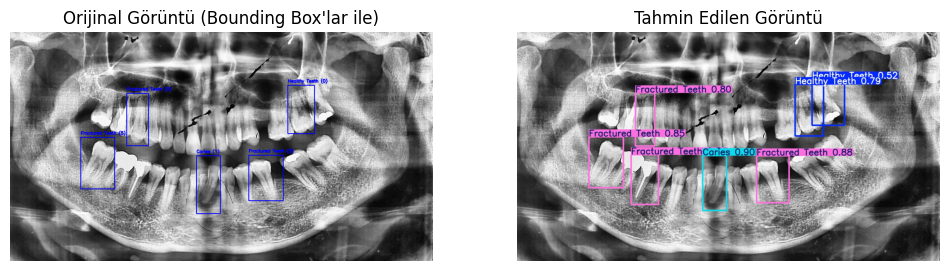

In [26]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import os

# Sınıf isimleri
class_names = ['Healthy Teeth', 'Caries', 'Impacted Teeth', 'BDC/BDR', 'Infection', 'Fractured Teeth']

# Modeli yükle
model = YOLO('C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/dental_detection/weights/best.pt')

# Yeni bir görüntü üzerinde tahmin yap
image_path = "C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/Original_Data/1.jpg"
results = model.predict(
    source=image_path,
    conf=0.25,
    save=True,
    project='C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/results',
    name='manual_test'
)

# Orijinal görüntüyü yükle
original_image = cv2.imread(image_path)

# Tahmin edilen görüntüyü yükle
result_image_path = f"C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/results/manual_test/{os.path.basename(image_path)}"
predicted_image = cv2.imread(result_image_path)

# Orijinal bounding box bilgilerini oku ve çiz
txt_path_original = f"C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/Dental OPG XRAY Dataset/Original_Data/{os.path.splitext(os.path.basename(image_path))[0]}.txt"
if os.path.exists(txt_path_original):
    with open(txt_path_original, "r") as f:
        boxes_original = f.readlines()

    for box in boxes_original:
        class_id, x_center, y_center, width, height = map(float, box.split())
        x1 = int((x_center - width / 2) * original_image.shape[1])
        y1 = int((y_center - height / 2) * original_image.shape[0])
        x2 = int((x_center + width / 2) * original_image.shape[1])
        y2 = int((y_center + height / 2) * original_image.shape[0])

        # Çerçeve çiz
        cv2.rectangle(original_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(original_image, f"{class_names[int(class_id)]} ({int(class_id)})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Tahmin bounding box bilgilerini oku ve tahmin edilen görüntü üzerine çiz
txt_path_predicted = f"C:/Users/Kullanıcı/Desktop/dentalyze_jupyter/results/manual_test/{os.path.splitext(os.path.basename(image_path))[0]}.txt"
if os.path.exists(txt_path_predicted):
    with open(txt_path_predicted, "r") as f:
        boxes_predicted = f.readlines()

    for box in boxes_predicted:
        class_id, x_center, y_center, width, height = map(float, box.split())
        x1 = int((x_center - width / 2) * predicted_image.shape[1])
        y1 = int((y_center - height / 2) * predicted_image.shape[0])
        x2 = int((x_center + width / 2) * predicted_image.shape[1])
        y2 = int((y_center + height / 2) * predicted_image.shape[0])

        # Çerçeve çiz
        cv2.rectangle(predicted_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(predicted_image, f"{class_names[int(class_id)]} ({int(class_id)})", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Görselleştirme
plt.figure(figsize=(12, 6))

# Orijinal görüntü
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title("Orijinal Görüntü (Bounding Box'lar ile)")
plt.axis("off")

# Tahmin edilen görüntü
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
plt.title("Tahmin Edilen Görüntü")
plt.axis("off")

plt.show()